In [ ]:

# pip install scikit-learn matplotlib opencv-python

In [ ]:
# pip install tensorflow -i https://pypi.python.org/simple --timeout 100


### Library

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, GaussianNoise, Input, Rescaling
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import ModelCheckpoint

### Data Ingetation

In [2]:
data = np.load(r"C:\Users\Admin\Downloads\pneumoniamnist.npz")

In [3]:
data["train_images"].shape, data["train_labels"].shape

((3882, 28, 28), (3882, 1))

### To fix the standard format

In [4]:
def normalization(image_set):
    min_val = np.min(image_set)
    max_val = np.max(image_set)
    difference = max_val - min_val
    return (image_set - min_val) / difference

### Reshape(batch_size, height, width, channels) for grayscale channels = 1

In [5]:
xtrain = normalization(data["train_images"].reshape(-1, 28, 28, 1))
ytrain = data["train_labels"]

xvalid = normalization(data["val_images"].reshape(-1, 28, 28, 1))
yvalid = data["val_labels"]

xtest  = normalization(data["test_images"].reshape(-1, 28, 28, 1))
ytest = data["test_labels"]

### For visualization

Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


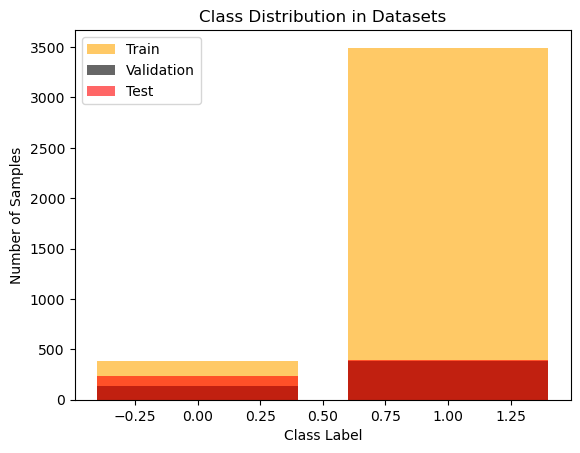

In [7]:
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")
# Optional: visualize imbalance
plt.bar(unique_train, counts_train, color='orange', alpha=0.6, label='Train')
plt.bar(unique_val, counts_val, color='black', alpha=0.6, label='Validation')
plt.bar(unique_test, counts_test, color='red', alpha=0.6, label='Test')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.legend()
plt.title("Class Distribution in Datasets")
plt.show()

#### Pie-Chart

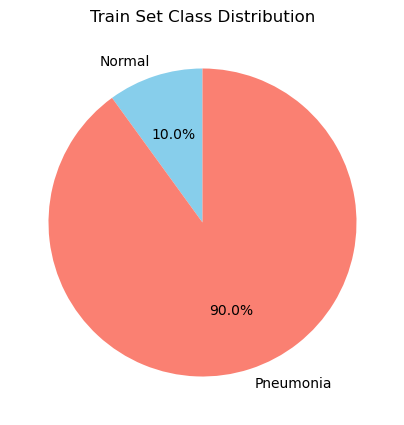

In [8]:
import matplotlib.pyplot as plt

labels = ['Normal', 'Pneumonia']

# Training Set
plt.figure(figsize=(5,5))
plt.pie(counts_train, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title("Train Set Class Distribution")
plt.show()


### Stacked Class Distrbution

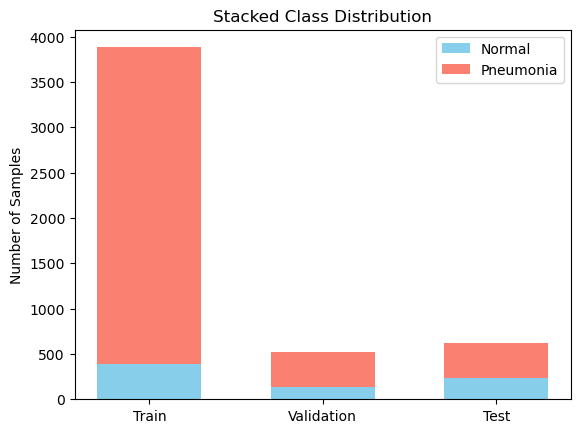

In [10]:
import numpy as np

labels = ['Normal', 'Pneumonia']
datasets = ['Train', 'Validation', 'Test']

# Combine into matrix
counts = np.array([counts_train, counts_val, counts_test])
counts = counts.T  # shape (2, 3): rows = classes, columns = datasets

x = np.arange(len(datasets))
width = 0.6

plt.bar(x, counts[0], width, label='Normal', color='skyblue')
plt.bar(x, counts[1], width, bottom=counts[0], label='Pneumonia', color='salmon')

plt.xticks(x, datasets)
plt.ylabel("Number of Samples")
plt.title("Stacked Class Distribution")
plt.legend()
plt.show()


### Agumentation for 1. Class Imbalance and 2. Overfitting (Lack of Generalization)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Identify class counts
unique_train, counts_train = np.unique(ytrain, return_counts=True)
majority_class_count = np.max(counts_train)

# Initialize augmentation generator
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=True,
)
augmented_images = []
augmented_labels = []

# Augment both classes to balance data, not just the minority
for cls in unique_train:
    cls_indices = np.where(ytrain.flatten() == cls)[0]
    cls_images = xtrain[cls_indices]
    cls_labels = ytrain[cls_indices]

    current_count = len(cls_indices)
    samples_needed = majority_class_count - current_count

    if samples_needed > 0:
        aug_per_sample = samples_needed // current_count + 1
        for img, lbl in zip(cls_images, cls_labels):
            aug_iter = datagen.flow(img.reshape(1, *img.shape), lbl.reshape(1, *lbl.shape), batch_size=1)
            for _ in range(aug_per_sample):
                aug_img, aug_lbl = next(aug_iter)
                augmented_images.append(aug_img[0])
                augmented_labels.append(aug_lbl[0])
                if len(augmented_labels) >= samples_needed:
                    break
            if len(augmented_labels) >= samples_needed:
                break

# Convert to arrays and reshape labels if necessary
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if ytrain.ndim == 2:
    augmented_labels = augmented_labels.reshape(-1, 1)
# Combine original and augmented data
xtrain_balanced = np.concatenate([xtrain, augmented_images], axis=0)
ytrain_balanced = np.concatenate([ytrain, augmented_labels], axis=0)

# Final distribution check
unique_bal, count_bal = np.unique(ytrain_balanced, return_counts=True)
print("After Augmentation:")
for cls, count in zip(unique_bal, count_bal):
    print(f"Class {cls}: {count} samples")

After Augmentation:
Class 0: 3494 samples
Class 1: 3494 samples


### Shuffling Dataset

#### 1. Prevent Learning from Data Order 2. Reduce Overfitting on Sequence Bias 3. Ensure Class Balance per Batch

In [12]:
def shuffle_dataset(x, y):
    assert len(x) == len(y), "Features and labels must have the same length"
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    return x[indices], y[indices]

for _ in range(10):
    xtrain_balanced, ytrain_balanced = shuffle_dataset(xtrain_balanced, ytrain_balanced)

### Customizing CNN for faster Training

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9162 - auc: 0.9730 - balanced_accuracy: 0.9164 - f1_score: 0.9134 - loss: 0.0456 - val_accuracy: 0.7424 - val_auc: 0.9527 - val_balanced_accuracy: 0.5000 - val_f1_score: 0.8521 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9635 - auc: 0.9957 - balanced_accuracy: 0.9637 - f1_score: 0.9636 - loss: 0.0105 - val_accuracy: 0.7424 - val_auc: 0.7832 - val_balanced_accuracy: 0.5000 - val_f1_score: 0.8521 - val_loss: 0.9359 - learning_rate: 0.0010
Epoch 3/15
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9657 - auc: 0.9961 - balanced_accuracy: 0.9658 - f1_score: 0.9656 - loss: 0.0094
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9656 - auc: 0.9961 - balanced_accuracy: 0.9657 - f1_score: 0.9655 - loss: 0.0094 - val_accuracy: 0.7424 - val_auc: 0.9738 - val_balanced_accur

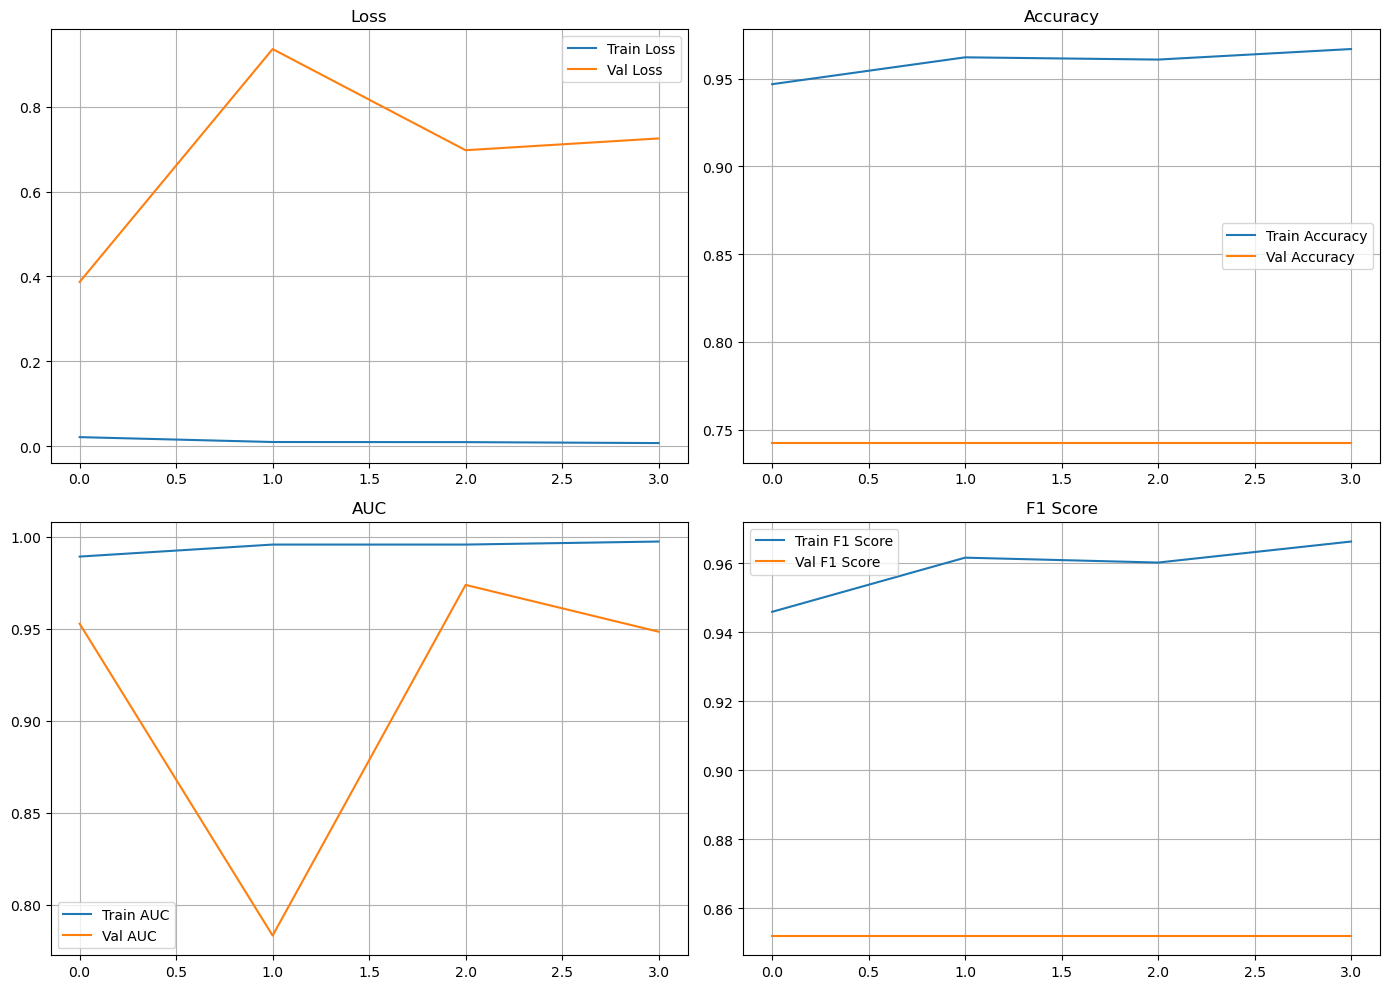

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Focal Loss Function
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

# ✅ Balanced Accuracy Metric
class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-7)
        specificity = self.tn / (self.tn + self.fp + 1e-7)
        return (recall + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

# ✅ F1 Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

# 1️⃣ Define CNN

def create_custom_cnn(input_shape=(28, 28, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# 2️⃣ Compile
model = create_custom_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=binary_focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), BalancedAccuracy(), F1Score()]
)

# 3️⃣ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# 4️⃣ Train
history = model.fit(
    xtrain_balanced, ytrain_balanced,
    validation_data=(xvalid, yvalid),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# 5️⃣ Evaluate
test_metrics = model.evaluate(xtest, ytest, verbose=0)
print(f"\nTest Loss: {test_metrics[0]:.4f}")
print(f"Test Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[3]:.4f}")
print(f"Test F1 Score: {test_metrics[4]:.4f}")

# 6️⃣ Plot

def plot_metrics(history):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Val F1 Score')
    plt.legend()
    plt.title('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(history)
